In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.isus_wang import (wang_act_and_kin,
                                   wang_act,
                                   wang_act_kin)
from experiments.isus_firek import (firek_inact)
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

In [5]:
modelfile = 'models/nygren_isus.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

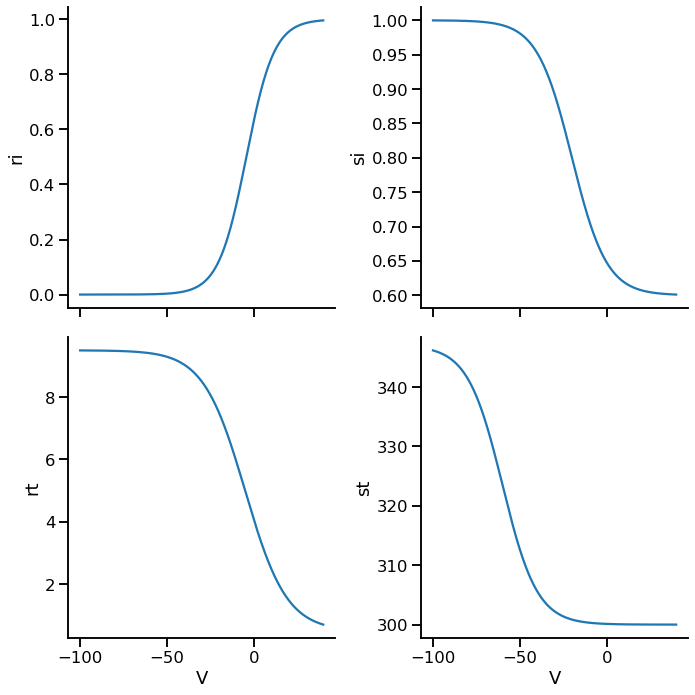

In [7]:
sns.set_context('talk')

V = np.arange(-100, 40, 0.01)

nyg_vars = {'ri': 'isus.r_inf',
            'si': 'isus.s_inf',
            'rt': 'isus.tau_r',
            'st': 'isus.tau_s'}

f, ax = plot_variables(V, nyg_vars, modelfile, figshape=(2,2))

## r gate -> activation data only

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act_and_kin)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

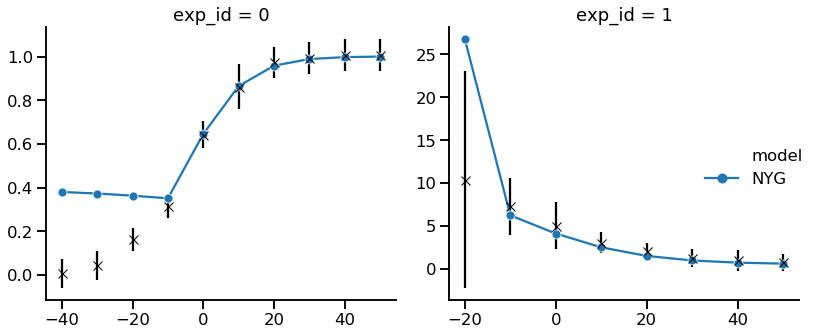

In [10]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin)

In [11]:
limits = {'isus.p1': (-100, 100),
          'isus.p2': (1e-7, 50),
          'log_isus.p3': (-5, 0),
          'isus.p4': (-100, 100),
          'isus.p5': (1e-7, 50),
          'log_isus.p6': (-6, -1)}
          #'isus.q1': (-100, 100),
          #'isus.q2': (1e-7, 50),
          #'isus.q3': (0., 1.),
          #'log_isus.q4': (-4, 1),
          #'isus.q5': (-100, 100),
          #'isus.q6': (1e-7, 50),
          #'log_isus.q7': (-3, 2)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_isus_rgate_reported.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2435658718644211, '1': 1.243311823678135, '2': 1.5188448657111304, '3': 1.519224008213791, '4': 1.3670286111645151, '5': 0.8044958859093764, '6': 1.1397025050382832, '7': 1.1399159724488552, '8': 1.1399159724488594, '9': 1.1397025050382832, '10': 0.08446935501503675, '11': 0.32315877006716853, '12': 0.3912264863854337, '13': 0.8745062636850891, '14': 1.1442949744557158, '15': 0.9908407438044368, '16': 0.8745062636850831, '17': 1.061289121386388}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-30 09:52:42.170175, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 948
DEBUG:Epsilon:new eps, t=1, eps=1.8482362538424795
INFO:ABC:t:1 eps:1.8482362538424795
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 2022
DEBUG:Epsilon:new eps, t=2, eps=1.2559647857588863
INFO:ABC:t:2 eps:1.2559647857588863
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 3185
DEBUG:Epsilon:new eps, t=3, eps=1.0877007372731602
INFO:ABC:t:3 eps:1.0877007372731602
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 4422
DEBUG:Epsilon:new eps, t=4, eps=1.0338740966404782
INFO:ABC:t:4 eps:1.0338740966404782
DEBUG:ABC:now submitting population 4


### Database results analysis

In [19]:
history = History(db_path)

In [20]:
df, w = history.get_distribution()

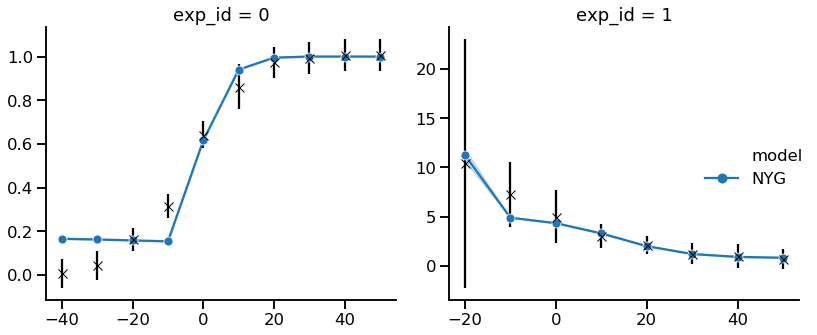

In [21]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     df=df, w=w)

In [22]:
nyg_pars = df.sample(n=100, weights=w, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

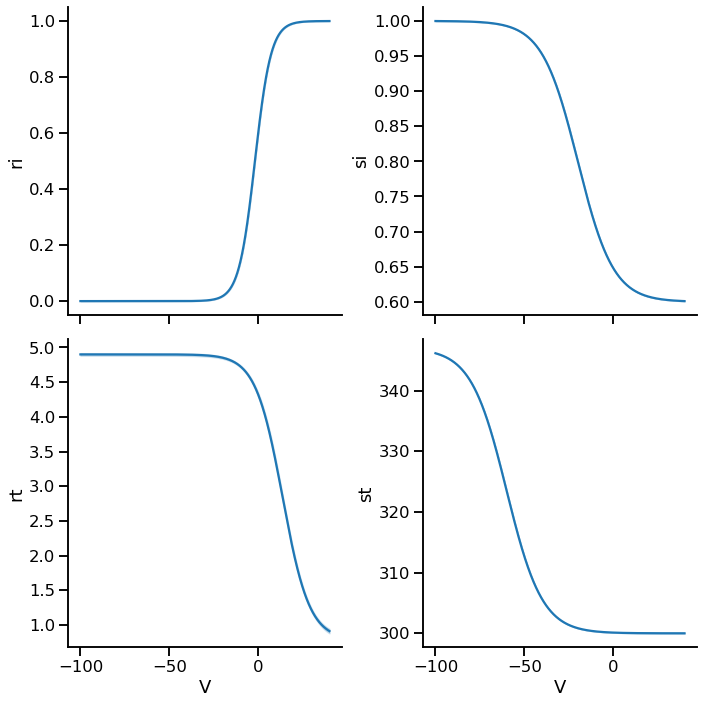

In [23]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_vars, 
                       'models/nygren_isus.mmt', 
                       [nyg_pars],
                       figshape=(2,2))

In [24]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [25]:
m,_,_ = myokit.load(modelfile)

In [26]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

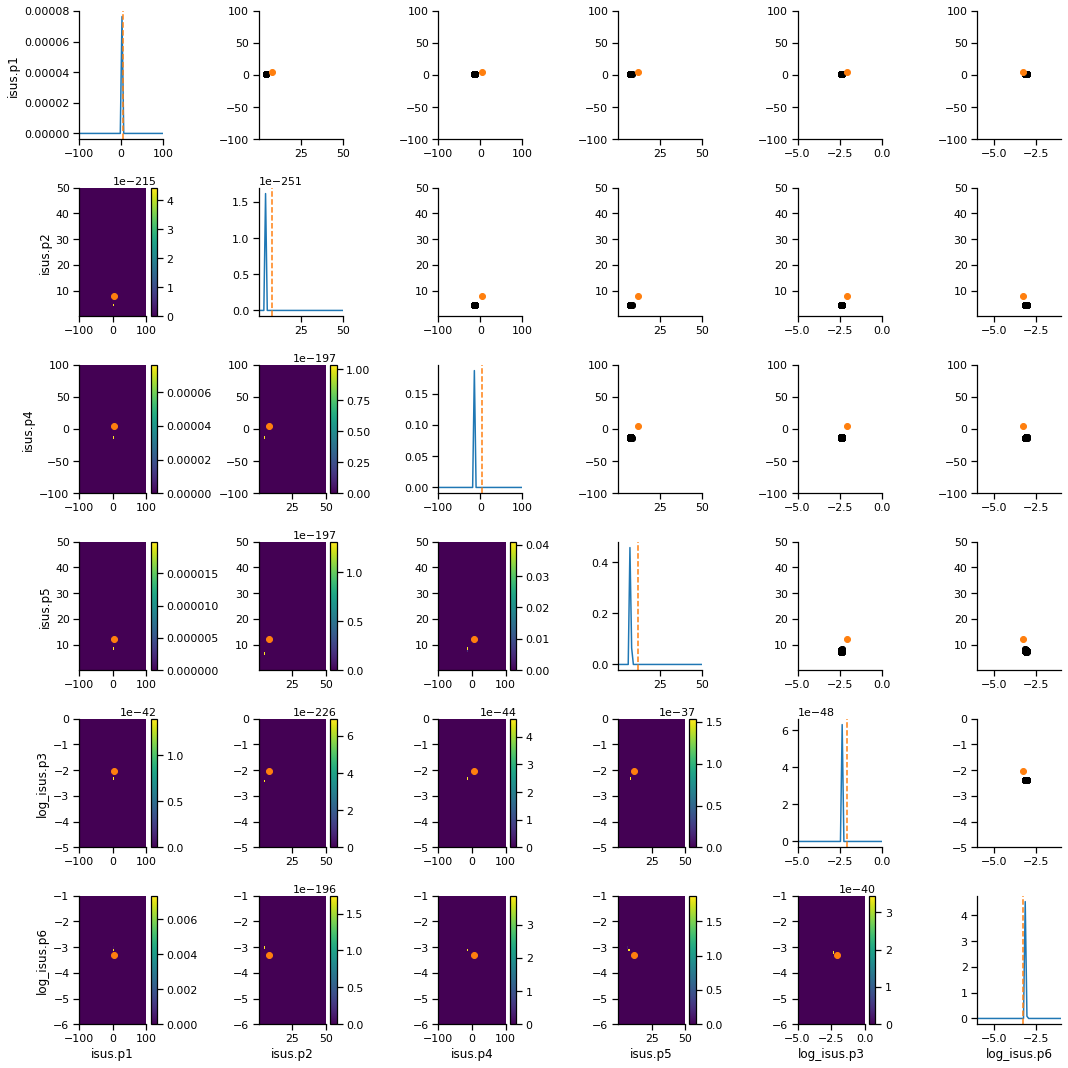

In [27]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

## s gate -> inactivation data only

In [11]:
observations, model, summary_statistics = setup(modelfile,
                                                firek_inact,
                                                nygren_inact_kin,
                                                nygren_rec)

In [12]:
assert len(observations)==len(summary_statistics(model({})))

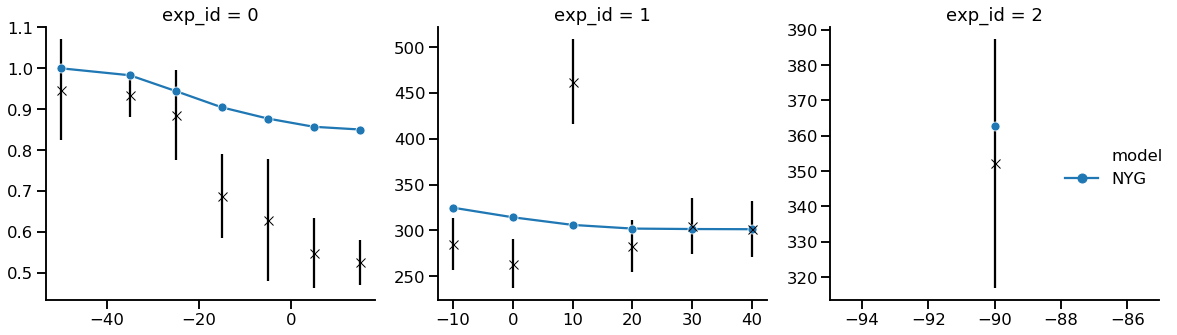

In [13]:
g = plot_sim_results(modelfile,
                     firek_inact,
                    nygren_inact_kin,
                    nygren_rec)

In [14]:
limits = {#'isus.p1': (-100, 100),
          #'isus.p2': (1e-7, 50),
          #'log_isus.p3': (-5, 0),
          #'isus.p4': (-100, 100),
          #'isus.p5': (1e-7, 50),
          #'log_isus.p6': (-6, -1)}
          'isus.q1': (-100, 100),
          'isus.q2': (1e-7, 50),
          'isus.q3': (0., 1.),
          'log_isus.q4': (-4, 1),
          'isus.q5': (-100, 100),
          'isus.q6': (1e-7, 50),
          'log_isus.q7': (-3, 2)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [22]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_isus_sgate_reported.db"))

In [23]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [24]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [18]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.4248110530506898, '1': 0.9476554260361589, '2': 0.47382771301807824, '3': 0.513313355769584, '4': 0.35198630109914286, '5': 0.6159760269235005, '6': 0.947655426036154, '7': 1.0466865780553765, '8': 1.1324846983182664, '9': 0.6459809613606208, '10': 1.0541409114085802, '11': 0.9789135226692829, '12': 0.9906822580908385, '13': 3.875885768163725}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [19]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [20]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-28 15:25:42.328733, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [25]:
history = History(db_path)

In [26]:
df, w = history.get_distribution()

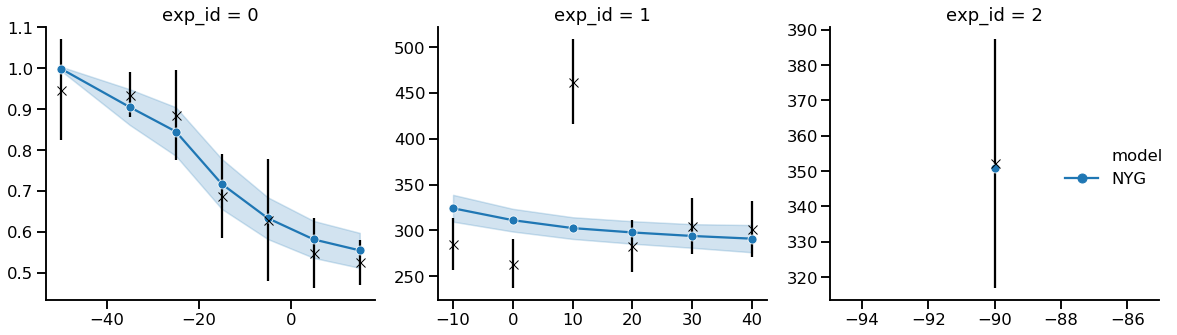

In [27]:
g = plot_sim_results(modelfile,
                     firek_inact,
                    nygren_inact_kin,
                    nygren_rec,
                     df=df, w=w)

In [28]:
nyg_pars = df.sample(n=100, weights=w, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

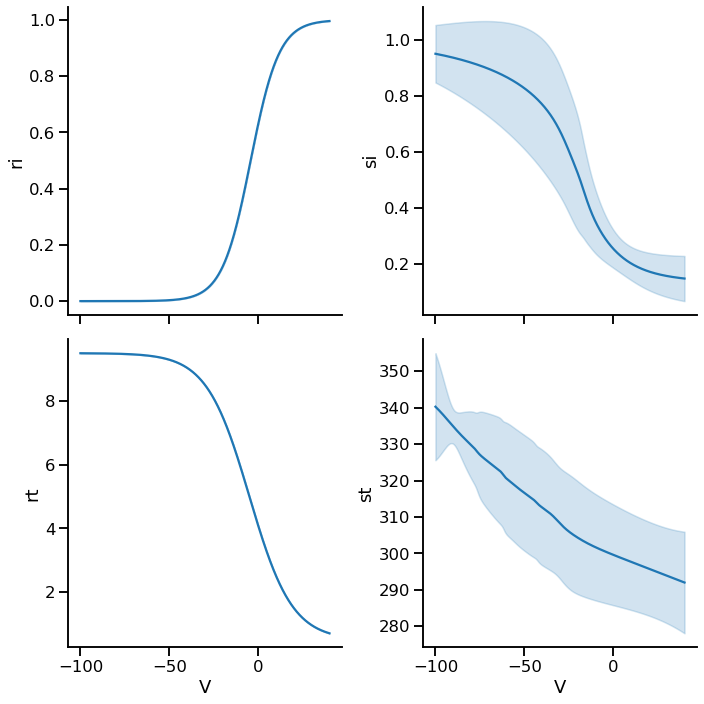

In [29]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_vars, 
                       'models/nygren_isus.mmt', 
                       [nyg_pars],
                       figshape=(2,2))

In [30]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [31]:
m,_,_ = myokit.load(modelfile)

In [32]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

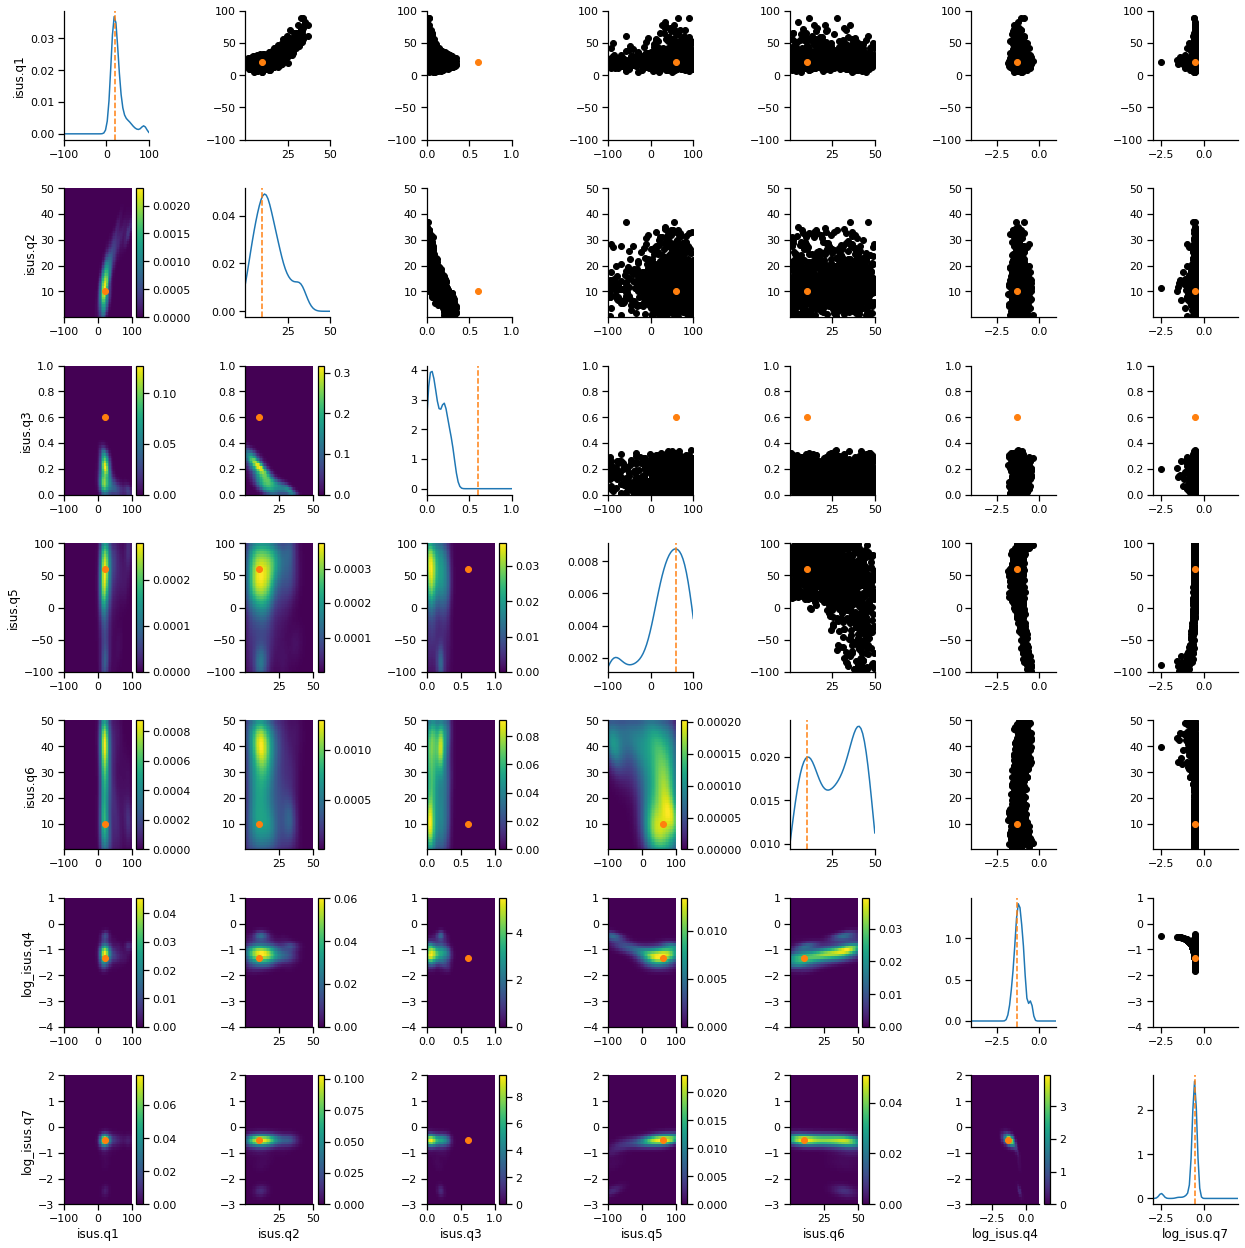

In [33]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)